# Lab 7 - Foraging

This lab has 4 main components designed to give provide an theoretical and experiental/interactive understanding of foraging in patchy environments.

Sections:
1. Consider foraging in "patchy" environments, and build a simulated patchy environment.
1. Predict and evaluate the behavior of agents with different exploration strategies in the patcy environment.
1. Predict and evaluate how agents' behavior & performance will change as characteristics of the patchy environment change.


## Background

### Real environments are "patchy".
- So far, we've been playing around with simulated environments where food ("targets") are spread uniformly over space.
- In reality, environments are often "patchy". For example, berries or flowers may be concentrated on isolated bushes, which are spaced apart from one another (see the natural environment below).
![natural patchy environment](https://cdn.pixabay.com/photo/2021/07/04/16/41/yakima-valley-6386896_1280.jpg)

### Patchy environments define the foraging problem.
- The problem of foraging requires that an organism navigate through an environment to find food, balancing the metabolic costs of movement with the energy provided by collected morsels.
- In an environment where targets are dispersed uniformly, foraging is rather simple - moving around from via some form of random walk, collecting targets, perhaps with behavior imformed by scent cues.
- A patchy environment complicates things - with no food in between patches, between-patch movement can become dangerous at long transit times. Patchy environments thus demand a foraging strategy that is sensitive to the sparsely-dense stucture of food availability.

### We can think of optimal foraging in terms of a simplified model.
- Charnov (1976) proposed a model of optimal foraging.
- Charnov's model formulates foraging space as divided into sections (patches) of different types, and the inter-patch space between them. See the illustration of this from his paper below (and consider how this simple model matches the real environment above so much better than uniformly distributed targets!).
![Charnov patch model illustration screenshot](https://raw.githubusercontent.com/CoAxLab/BiologicallyIntelligentExploration/main/Labs/Charnov_patches_screenshot.png)
- When we think about foraging in this way, it becomes clear that there is an important distinction between time spent *in* and *between* patches.
- Critically, off-patch time and on-patch time (for different patch types) determines energy intake rate for organisms.
- In Charnov's model, within-patch energy is depleted as a forager consumes the energy within that patch. Thus there is a point at which an optimal forager should leave a patch in aims of finding another. This is where the formulas in his marginal value come into play.

Next up, let's get set up to run some patch environment simulations!

## Section - Setup

We need to load the usual explorationlib library and supporting functions. For this lab specifically, we will be loading a certain *branch* of exploration library - one where I have coded functions for the creation and evaluation of behavior in patchy environments.

Change the directory to where we want to clone in the specific explorationlib code library branch.

In [29]:
cd /content

/content


Clone in the `target-patch-dev` explorationlib branch (the branch that has our new patchy environment functions).

In [30]:
!git clone -b target-patch-dev https://github.com/coaxlab/explorationlib

fatal: destination path 'explorationlib' already exists and is not an empty directory.


Change the working directory to the cloned library, so that we can load modules from it later on.

In [31]:
cd /content/explorationlib

/content/explorationlib


Install some other supporting code libraries, like gym-maze, which some explorationlib simulated environment code relies on.

In [32]:
!pip install --upgrade git+https://github.com/MattChanTK/gym-maze.git
!pip install celluloid # for the gifs

  Cloning https://github.com/MattChanTK/gym-maze.git to /tmp/pip-req-build-xm8b7jvu
  Running command git clone --filter=blob:none --quiet https://github.com/MattChanTK/gym-maze.git /tmp/pip-req-build-xm8b7jvu
  Resolved https://github.com/MattChanTK/gym-maze.git to commit 83176811b49b5538a6213520612f44fb1bc49114
  Preparing metadata (setup.py) ... done


Import specific modules from the libraries we loaded. We'll use these modules to create and plot enviornments, run experiments with different exploration agents in these environments, visualize their behaviors, and evaluate their performance according to various metrics.

In [33]:
# Import misc
import shutil
import glob
import os
import copy
import sys

# Vis - 1
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Exp
from explorationlib.run import experiment
from explorationlib.util import select_exp
from explorationlib.util import load
from explorationlib.util import save

# Agents
from explorationlib.agent import DiffusionGrid
from explorationlib.agent import DiffusionDiscrete
from explorationlib.agent import GradientDiffusionGrid
from explorationlib.agent import GradientDiffusionDiscrete
from explorationlib.agent import AccumulatorGradientGrid
from explorationlib.agent import AccumulatorInfoGrid
from explorationlib.agent import TruncatedLevyDiscrete

# Env
from explorationlib.local_gym import ScentGrid
from explorationlib.local_gym import create_grid_scent
from explorationlib.local_gym import create_grid_scent_patches
from explorationlib.local_gym import uniform_targets
from explorationlib.local_gym import uniform_patch_targets
from explorationlib.local_gym import constant_values

# Vis - 2
from explorationlib.plot import plot_position2d
from explorationlib.plot import plot_length_hist
from explorationlib.plot import plot_length
from explorationlib.plot import plot_targets2d
from explorationlib.plot import plot_scent_grid

# Score
from explorationlib.score import total_reward
from explorationlib.score import num_death
from explorationlib.score import on_off_patch_time

## Section 1 - Building a simulated patchy environment

- Below is some environment setup code that should look pretty standard compared to the previous labs you've seen in this class.
- The key difference is the generation of targets using a new function, `uniform_patch_targets()` - in other labs we've only used `uniform_targets()`.
- This new function randomly places circular patches in the environment, and then places targets at random with uniform probability within each patch.
- To specify the characteristics of the patchy environment we want to generate, we supply information about how many patches we want (`n_patches`), how many targets we want per patch (`n_per_patch`), and how large we want each patch to be (`radius`).
- To be clear, our simulation won't be perfect - this function can create overlapping patches, and our simulations don't take into account the depletion of patches over time.

Fill in the code below and run to create a patch environmet with *7 patches* of *10 targets each*. Make each patch have a *radius of 2 units*.

In [34]:
# Noise and missing scents
p_scent = 0.5
noise_sigma = 1

# Shared agent parameters
num_experiments = 50
num_steps = 400
seed_value = 6074

# Environment parameters
detection_radius = 1
max_steps = 1
min_length = 1
n_patches = 7 # FILL IN         # number of patches
n_per_patch = 10 # FILL IN      # number targets per patch
radius = 2 # FILL IN            # radius of each patch
target_boundary = (10, 10)

# Generate patches of argets
prng = np.random.RandomState(seed_value)
targets, patch_locs = uniform_patch_targets(n_patches, target_boundary, radius, n_per_patch, prng=prng)

values = constant_values(targets, 1)

# Generate scents from targets
scents = []
for _ in range(len(targets)):
    coord, scent = create_grid_scent_patches(
        target_boundary, p=1.0, amplitude=1, sigma=2)
    scents.append(scent)

# Create ScentGrid environment
env = ScentGrid(mode=None)
env.seed(seed_value)
env.add_scents(targets, values, coord, scents, noise_sigma=noise_sigma)

### Visualizing this environment

Run the code below to visualize the patchy environment that you just built!

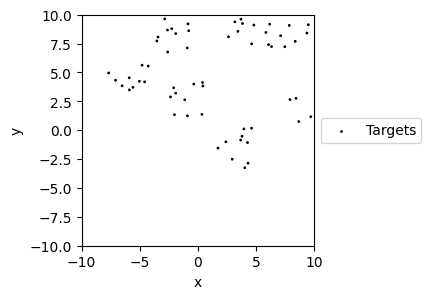

In [35]:
plot_boundary = (10, 10)
num_experiment = 0
ax = None
ax = plot_targets2d(
    env,
    boundary=plot_boundary,
    color="black",
    alpha=1,
    label="Targets",
    ax=ax,
)

## Section 2 - Different exploration strategies in the patchy environment

Now we will predict and evaluate the behavior of agents with different exploration strategies in the patcy environment. These are agents that we have used in pervious labs. See those labs to remember how these agents work.

Here we will generate 2 different types of agents - one that moves randomly (diffusion on the grid), and one that follows chemical signals emitted by targets (chemotaxis)

In [36]:
# Agents

# Random search agent
diff = DiffusionGrid(min_length=min_length, scale=1)
diff.seed(seed_value)

drift_rate = 1
threshold = 3

# Chemotaxis agent
chemo = AccumulatorGradientGrid(
    min_length=min_length,
    max_steps=max_steps,
    drift_rate=drift_rate,
    threshold=threshold,
    accumulate_sigma=1
)
chemo.seed(seed_value)

[6074]

**Note:** you may like to start the next experiments running as you answer these questions.

### Question 2.1

Which agent do you think will spend the most time in patches? Which agent do you think will spend the least time in patches? Why?

In [37]:
# Write your answer here as a comment. Explain yourself.

### Question 2.2

Which agent do you think will accumulate the most reward (spend the most time next to targets?). Which do you think will spend the least? Why?

In [38]:
# Write your answer here as a comment. Explain yourself.

### Question 2.3

Which agent do you think will have the most deaths? Which do you think will have the least? Why?

In [39]:
# Write your answer here as a comment. Explain yourself.

Run the code below to perform a number of experiments, simulating how these different agents behave in the patch environment that you built.

In [40]:
# Experiments
rand_exp = experiment(
    f"rand",
    diff,
    env,
    num_steps=num_steps,
    num_experiments=num_experiments,
    dump=False,
    split_state=True,
    seed=seed_value
)
chemo_exp = experiment(
    f"chemo",
    chemo,
    env,
    num_steps=num_steps,
    num_experiments=num_experiments,
    dump=False,
    split_state=True,
    seed=seed_value
)

rand:   0%|          | 0/50 [00:00<?, ?it/s]

chemo:   0%|          | 0/50 [00:00<?, ?it/s]

Run the code below to plot behavior of each agent type during one experiment example.

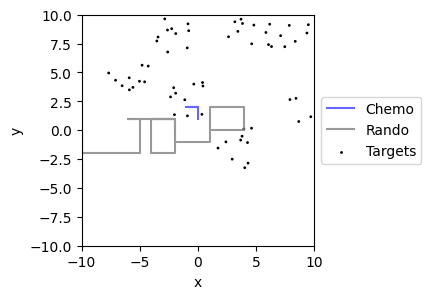

In [41]:
plot_boundary = (10, 10)

# -
num_experiment = 5
ax = None
ax = plot_position2d(
    select_exp(chemo_exp, num_experiment),
    boundary=plot_boundary,
    label="Chemo",
    color="blue",
    alpha=0.6,
    ax=ax,
)
ax = plot_position2d(
    select_exp(rand_exp, num_experiment),
    boundary=plot_boundary,
    label="Rando",
    color="grey",
    alpha=0.8,
    ax=ax,
)
ax = plot_targets2d(
    env,
    boundary=plot_boundary,
    color="black",
    alpha=1,
    label="Targets",
    ax=ax,
)

### Question 2.4

Describe the behavior of each agent type in the experiment visualization above. Does the behavior match what you expected? Why do you think you see the specific pattern of behavior for each agent?

In [42]:
# Write your answer here as a comment. Explain yourself.

### Quantify time on-patches for each agent type

The code below makes use of a new scoring function, `on_off_patch_time()`. This function takes experiment results data and analyzes it to see how many time steps were spent on vs. off patches. Run the code block below to measure and plot the proportion of total time steps each agent spends on patches. See if the results match your predictions.

on_off_patch_time:   0%|          | 0/50 [00:00<?, ?it/s]

on_off_patch_time:   0%|          | 0/50 [00:00<?, ?it/s]

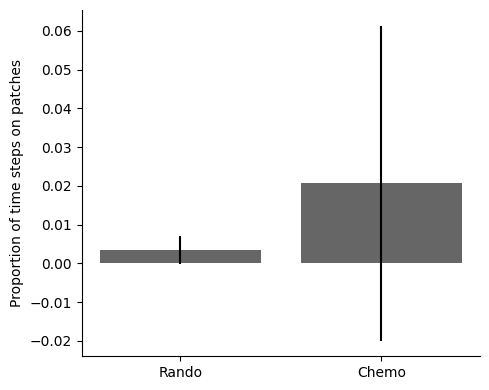

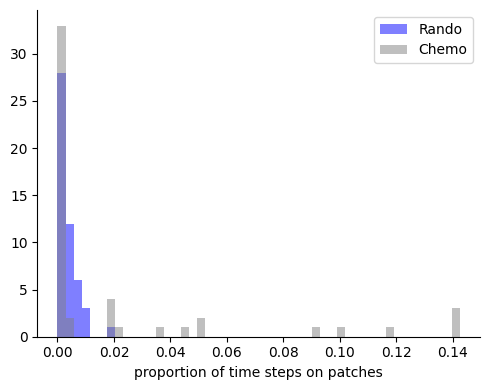

In [43]:
# Results
results = [rand_exp, chemo_exp]
names = ["Rando", "Chemo"]
colors = ["blue", "grey"]

# Score by on_patch_time #eff
scores = []
for name, res, color in zip(names, results, colors):
    #scores.append(num_death(res))
    on_patch_steps, off_patch_steps = on_off_patch_time(res, num_experiments, patch_locs, radius)
    scores.append(np.divide(on_patch_steps,(np.array(on_patch_steps) + off_patch_steps)))

# Tabulate
m, sd = [], []
for (name, s, c) in zip(names, scores, colors):
    m.append(np.mean(s))
    sd.append(np.std(s))

# Plot means
fig = plt.figure(figsize=(5, 4))
plt.bar(names, m, yerr=sd, color="black", alpha=0.6)
plt.ylabel("Proportion of time steps on patches")
plt.tight_layout()
sns.despine()

# Dists
fig = plt.figure(figsize=(5, 4))
for (name, s, c) in zip(names, scores, colors):
    plt.hist(s, label=name, color=c, alpha=0.5, bins=np.linspace(0, np.max(scores), 50))
    plt.legend()
    plt.xlabel("proportion of time steps on patches")
    plt.tight_layout()
    sns.despine()

### Quantify total reward for each agent type

Check if your predictions were correct.

total_reward:   0%|          | 0/50 [00:00<?, ?it/s]

total_reward:   0%|          | 0/50 [00:00<?, ?it/s]

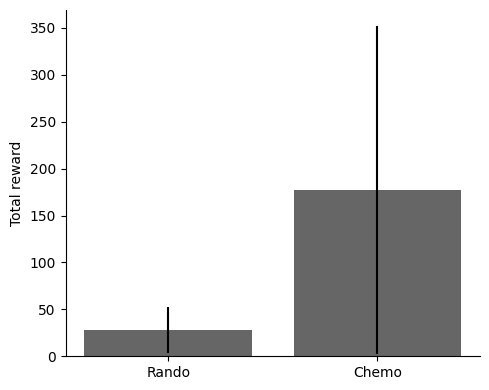

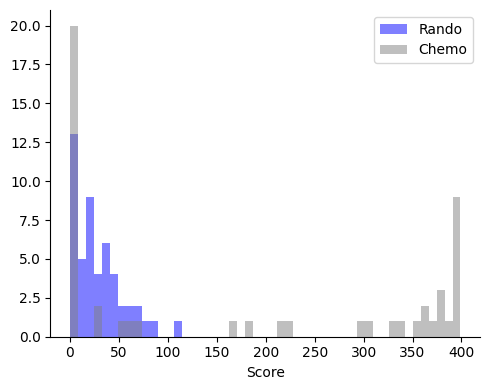

In [44]:
# Results
results = [rand_exp, chemo_exp]
names = ["Rando", "Chemo"]
colors = ["blue", "grey"]

# Score by eff
scores = []
for name, res, color in zip(names, results, colors):
    r = total_reward(res)
    scores.append(r)

# Tabulate
m, sd = [], []
for (name, s, c) in zip(names, scores, colors):
    m.append(np.mean(s))
    sd.append(np.std(s))

# Plot means
fig = plt.figure(figsize=(5, 4))
plt.bar(names, m, yerr=sd, color="black", alpha=0.6)
plt.ylabel("Total reward")
plt.tight_layout()
sns.despine()

# Dists
fig = plt.figure(figsize=(5, 4))
for (name, s, c) in zip(names, scores, colors):
    plt.hist(s, label=name, color=c, alpha=0.5, bins=np.linspace(0, np.max(scores), 50))
    plt.legend()
    plt.xlabel("Score")
    plt.tight_layout()
    sns.despine()

### Quantify deaths for each agent type

Check if your predictions were correct.

num_death:   0%|          | 0/50 [00:00<?, ?it/s]

num_death:   0%|          | 0/50 [00:00<?, ?it/s]

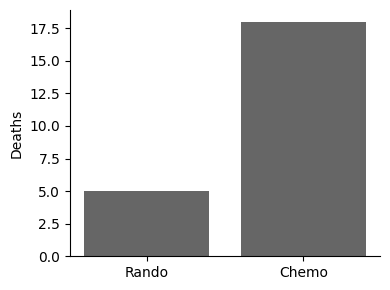

In [45]:
# Results
results = [rand_exp, chemo_exp]
names = ["Rando", "Chemo"]
colors = ["blue", "grey"]

# Score by eff
scores = []
for name, res, color in zip(names, results, colors):
    scores.append(num_death(res))

# Tabulate
m, sd = [], []
for (name, s, c) in zip(names, scores, colors):
    m.append(np.mean(s))
    sd.append(np.std(s))

# Plot means
fig = plt.figure(figsize=(4, 3))
plt.bar(names, m, yerr=sd, color="black", alpha=0.6)
plt.ylabel("Deaths")
plt.tight_layout()
sns.despine()

### Question 2.5

Were any of your predictions wrong? If so, what do you think caused the unexpected results?

In [46]:
# Write your answer here as a comment. Explain yourself.

### Question 2.6

Compare time on patch, total rewards, and deaths for the Chemo agent. What does this pattern tell you about the influence of a simple chemotaxis strategy for foraging?

In [47]:
# Write your answer here as a comment. Explain yourself.

## Section 3 - Exploration strategies in different patchy environments

## Question 3.1

Next, try creating a new patch environment just like our first one, but with only two patches of 20 targets each. Make predictions as to how the performance of each agent type will change and why. Make predictions for on-patch-proportion, total reward, and death.

In [48]:
# Add your predictions here, as a python comment in this cell below.

In [49]:
# Noise and missing scents
p_scent = 0.5
noise_sigma = 1

# Shared agent parameters
num_experiments = 50
num_steps = 400
seed_value = 5074               # seed value for random number generator

# Environment parameters
detection_radius = 1
max_steps = 1
min_length = 1
n_patches = 2 # FILL IN         # number of patches
n_per_patch = 20 # FILL IN      # number targets per patch
radius = 2 # FILL IN            # radius of each patch
target_boundary = (10, 10)

# Generate patches of argets
prng = np.random.RandomState(seed_value)
targets, patch_locs = uniform_patch_targets(n_patches, target_boundary, radius, n_per_patch, prng=prng)

values = constant_values(targets, 1)

# Generate scents from targets
scents = []
for _ in range(len(targets)):
    coord, scent = create_grid_scent_patches(
        target_boundary, p=1.0, amplitude=1, sigma=2)
    scents.append(scent)

# Create ScentGrid environment
env = ScentGrid(mode=None)
env.seed(seed_value)
env.add_scents(targets, values, coord, scents, noise_sigma=noise_sigma)

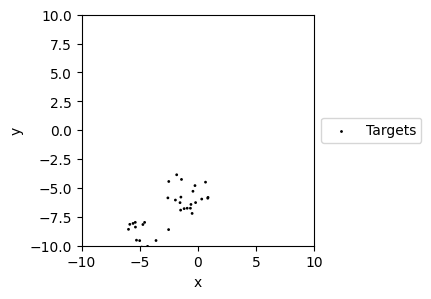

In [50]:
plot_boundary = (10, 10)
num_experiment = 0
ax = None
ax = plot_targets2d(
    env,
    boundary=plot_boundary,
    color="black",
    alpha=1,
    label="Targets",
    ax=ax,
)

In [51]:
# Experiments
rand_exp = experiment(
    f"rand",
    diff,
    env,
    num_steps=num_steps,
    num_experiments=num_experiments,
    dump=False,
    split_state=True,
    seed=seed_value
)
chemo_exp = experiment(
    f"chemo",
    chemo,
    env,
    num_steps=num_steps,
    num_experiments=num_experiments,
    dump=False,
    split_state=True,
    seed=seed_value
)

rand:   0%|          | 0/50 [00:00<?, ?it/s]

chemo:   0%|          | 0/50 [00:00<?, ?it/s]

on_off_patch_time:   0%|          | 0/50 [00:00<?, ?it/s]

on_off_patch_time:   0%|          | 0/50 [00:00<?, ?it/s]

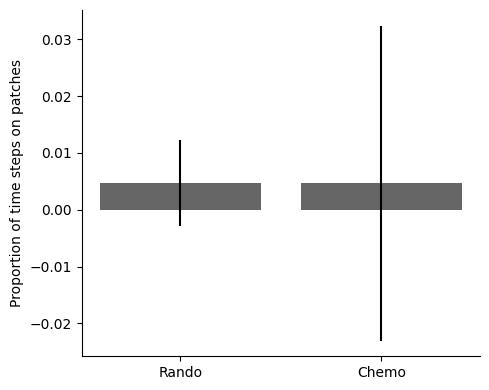

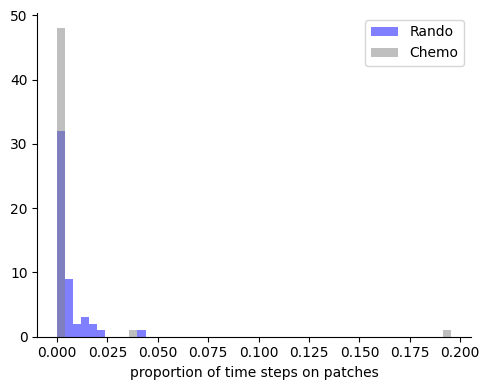

In [52]:
# Results
results = [rand_exp, chemo_exp]
names = ["Rando", "Chemo"]
colors = ["blue", "grey"]

# Score by on_patch_time #eff
scores = []
for name, res, color in zip(names, results, colors):
    #scores.append(num_death(res))
    on_patch_steps, off_patch_steps = on_off_patch_time(res, num_experiments, patch_locs, radius)
    scores.append(np.divide(on_patch_steps,(np.array(on_patch_steps) + off_patch_steps)))

# Tabulate
m, sd = [], []
for (name, s, c) in zip(names, scores, colors):
    m.append(np.mean(s))
    sd.append(np.std(s))

# Plot means
fig = plt.figure(figsize=(5, 4))
plt.bar(names, m, yerr=sd, color="black", alpha=0.6)
plt.ylabel("Proportion of time steps on patches")
plt.tight_layout()
sns.despine()

# Dists
fig = plt.figure(figsize=(5, 4))
for (name, s, c) in zip(names, scores, colors):
    plt.hist(s, label=name, color=c, alpha=0.5, bins=np.linspace(0, np.max(scores), 50))
    plt.legend()
    plt.xlabel("proportion of time steps on patches")
    plt.tight_layout()
    sns.despine()

total_reward:   0%|          | 0/50 [00:00<?, ?it/s]

total_reward:   0%|          | 0/50 [00:00<?, ?it/s]

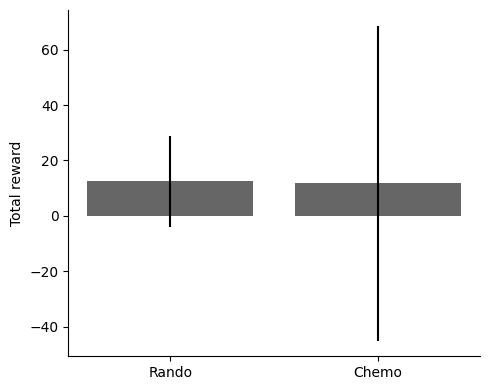

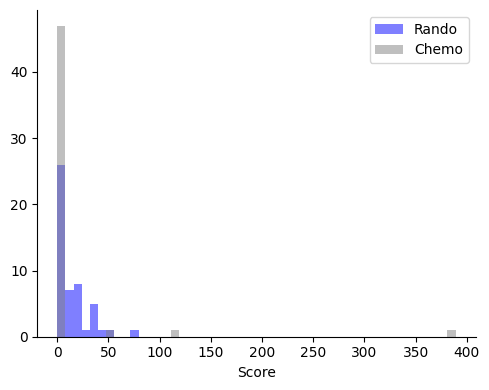

In [53]:
# Results
results = [rand_exp, chemo_exp]
names = ["Rando", "Chemo"]
colors = ["blue", "grey"]

# Score by eff
scores = []
for name, res, color in zip(names, results, colors):
    r = total_reward(res)
    scores.append(r)

# Tabulate
m, sd = [], []
for (name, s, c) in zip(names, scores, colors):
    m.append(np.mean(s))
    sd.append(np.std(s))

# Plot means
fig = plt.figure(figsize=(5, 4))
plt.bar(names, m, yerr=sd, color="black", alpha=0.6)
plt.ylabel("Total reward")
plt.tight_layout()
sns.despine()

# Dists
fig = plt.figure(figsize=(5, 4))
for (name, s, c) in zip(names, scores, colors):
    plt.hist(s, label=name, color=c, alpha=0.5, bins=np.linspace(0, np.max(scores), 50))
    plt.legend()
    plt.xlabel("Score")
    plt.tight_layout()
    sns.despine()

num_death:   0%|          | 0/50 [00:00<?, ?it/s]

num_death:   0%|          | 0/50 [00:00<?, ?it/s]

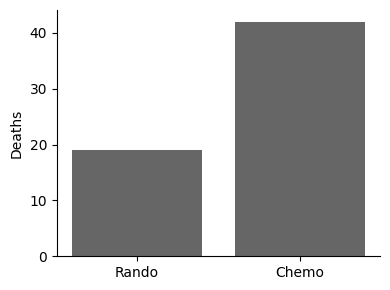

In [54]:
# Results
results = [rand_exp, chemo_exp]
names = ["Rando", "Chemo"]
colors = ["blue", "grey"]

# Score by eff
scores = []
for name, res, color in zip(names, results, colors):
    scores.append(num_death(res))

# Tabulate
m, sd = [], []
for (name, s, c) in zip(names, scores, colors):
    m.append(np.mean(s))
    sd.append(np.std(s))

# Plot means
fig = plt.figure(figsize=(4, 3))
plt.bar(names, m, yerr=sd, color="black", alpha=0.6)
plt.ylabel("Deaths")
plt.tight_layout()
sns.despine()

### Question 3.2

Did the results match your predictions? If not, why do you think you saw the results that came up?

In [55]:
# Write your answer here as a comment. Explain yourself.

### Question 3.3

Re-run the above simulations in Section 3, but change the seed value for the random number generator. Do this four different times, once each with the following values: 2074, 3074, 4074, 5074.

What do you see in the performance of the agents with each new seed value (which specifies different unique environments)?

In [56]:
# Write your answer here as a comment. Explain yourself.